In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tsai.basics import *

v:\Git\Donguri\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
my_setup()

os              : Windows-10-10.0.19045-SP0
python          : 3.9.19
tsai            : 0.3.9
fastai          : 2.7.14
fastcore        : 1.5.32
torch           : 2.1.2+cu118
device          : 1 gpu (['NVIDIA GeForce GTX 1080 Ti'])
cpu cores       : 4
threads per cpu : 2
RAM             : 31.94 GB
GPU memory      : [11.0] GB


In [3]:
set_seed(137, False)

In [4]:
if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")  # Use GPU

Using GPU


# Global variables

In [ ]:
use_optuna = False

# Define training data

In [5]:
train_df = pd.read_csv("data/for_model/train_default_scaled.csv")
train_df

,Timestamp,BP_Real Upper Band,BP_Real Middle Band,BP_Real Lower Band,BP_treasuryStock,BP_inventory,BP_investments,BP_totalNonCurrentAssets,CMCSA_Real Upper Band,CMCSA_Real Middle Band,...,IBM_Close,INTC_Close,MAA_Close,ORCL_Close,PG_Close,QCOM_Close,STZ_Close,UL_Close,VZ_Close,XOM_Close
0,2010-08-31,-1.242518,-1.709680,-2.056687,4.414049,0.023902,0.0,-2.459794,-1.699364,-1.713887,...,-1.533247,-1.445331,-1.382686,-2.188371,-1.374900,-1.994783,-1.435919,-1.944305,-2.674190,-1.630094
1,2010-09-01,-1.247530,-1.697027,-2.027156,4.414049,0.023902,0.0,-2.459794,-1.699551,-1.714217,...,-1.427220,-1.406089,-1.288447,-2.100215,-1.367751,-1.897282,-1.431694,-1.883862,-2.570287,-1.493867
2,2010-09-02,-1.255403,-1.682635,-1.991332,4.414049,0.023902,0.0,-2.459794,-1.699626,-1.714417,...,-1.456538,-1.394523,-1.290304,-2.116140,-1.352903,-1.865533,-1.427610,-1.888030,-2.591637,-1.482515
3,2010-09-03,-1.264124,-1.665575,-1.949560,4.414049,0.023902,0.0,-2.459794,-1.699561,-1.714187,...,-1.354527,-1.382131,-1.278234,-2.066091,-1.340804,-1.838481,-1.425357,-1.882819,-2.578827,-1.462838
4,2010-09-07,-1.289483,-1.643391,-1.881070,4.414049,0.023902,0.0,-2.459794,-1.699645,-1.713927,...,-1.419991,-1.407741,-1.352511,-1.913098,-1.349053,-1.824203,-1.428877,-1.921378,-2.575980,-1.521113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255,2023-08-08,2.280115,2.422957,2.391731,1.224302,0.254223,0.0,-1.600688,1.829710,1.709277,...,-0.618362,-0.011573,2.755026,8.434078,3.982483,3.968747,2.145830,0.715205,-2.241496,2.049552
3256,2023-08-09,2.304422,2.432822,2.386337,1.224302,0.254223,0.0,-1.600688,1.844691,1.721492,...,-0.755715,-0.072707,2.763382,8.191793,3.971485,3.886839,2.139633,0.719373,-2.221569,2.188050
3257,2023-08-10,2.332459,2.446714,2.384977,1.224302,0.254223,0.0,-1.600688,1.865860,1.735285,...,-0.725192,-0.039661,2.689569,8.179280,3.928590,3.814699,2.112312,0.733963,-2.177446,2.230432
3258,2023-08-11,2.336006,2.463488,2.413862,1.224302,0.254223,0.0,-1.600688,1.881683,1.749048,...,-0.730413,-0.022312,2.693283,8.187243,3.978634,3.739554,2.099215,0.699573,-2.129052,2.359848


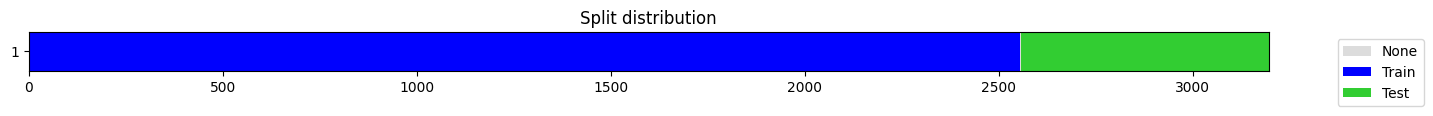

((#2554) [0,1,2,3,4,5,6,7,8,9...],
 (#638) [2558,2559,2560,2561,2562,2563,2564,2565,2566,2567...])

In [6]:
fcst_history = 60 # steps in the past
fcst_horizon = 5 # steps in the future
valid_size   = 0.2  # int or float indicating the size of the training set
test_size    = 0.0  # int or float indicating the size of the test set

splits = get_forecasting_splits(train_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col="Timestamp",
                                valid_size=valid_size, test_size=test_size)
splits

In [7]:
X = np.load("data/for_model/X_scaled_default_14.npy")
y = np.load("data/for_model/y_scaled_default.npy")
X_train, y_train = X[splits[0]], y[splits[0]]
X_val, y_val = X[splits[1]], y[splits[1]]

batch_size = 16

# Convert lists to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders with shuffle=False
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Check that the data is correct (sliding window)

In [8]:
print(X[1][0][-1], y[0][0][0])

0.3105332198504592 0.3105332198504592


# Callbacks

In [9]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.num_bad_epochs = 0
        self.is_better = None

    def __call__(self, val_loss):
        if self.is_better is None:
            self.is_better = lambda val_loss, best_loss: val_loss < best_loss - self.min_delta
        if self.is_better(val_loss, self.best_loss):
            self.num_bad_epochs = 0
            self.best_loss = val_loss
        else:
            self.num_bad_epochs += 1
        if self.num_bad_epochs >= self.patience:
            return True
        return False


class SaveBestModel:
    def __init__(self, model, save_path):
        self.model = model
        self.best_loss = float('inf')
        self.best_epoch = -1
        self.best_state_dict = None
        self.save_path = save_path

    def __call__(self, epoch, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_epoch = epoch
            self.best_state_dict = self.model.state_dict()

            torch.save(self.best_state_dict, self.save_path)

    def restore_best_model(self):
        if self.best_state_dict is not None:
            self.model.load_state_dict(self.best_state_dict)


class BestValLossTracker:
    def __init__(self):
        self.best_val_loss = float('inf')

    def update(self, val_loss):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss

    def get_best_val_loss(self):
        return self.best_val_loss

# Optuna

In [ ]:
n_layers_ = [4, 6, 8]
n_heads_ = [3, 4, 6]
d_model_ = [12, 24, 48]
d_ff_ = [128, 256, 512]
patch_len_ = [15, 20, 30]
stride_ = [1, 3, 5]
n_epochs = 35

In [ ]:
def objective(trial:optuna.Trial):
    
    # Parameters
    t_n_layers = trial.suggest_categorical("n_layers", n_layers_)
    t_n_heads = trial.suggest_categorical("n_heads", n_heads_)
    t_d_model = trial.suggest_categorical("d_model", d_model_)
    t_d_ff = trial.suggest_categorical("d_ff", d_ff_)
    t_attn_dropout = trial.suggest_float("attn_dropout", 0.0, 0.3, step=.1)
    t_dropout = trial.suggest_float("dropout", 0.3, 0.5, step=.1)
    t_patch_len = trial.suggest_categorical("patch_len", patch_len_)
    t_stride = trial.suggest_categorical("stride", stride_)
    t_padding_patch = True
    t_learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    
    # Model
    learn = TSForecaster(X, y, splits=splits, 
        batch_size=batch_size, 
        path="models", 
        arch="PatchTST", 
        arch_config={
            'n_layers':t_n_layers, 
            'n_heads':t_n_heads, 
            'd_model':t_d_model,
            'd_ff':t_d_ff, 
            'attn_dropout':t_attn_dropout, 
            'dropout':t_dropout,
            'patch_len': t_patch_len,
            'stride': t_stride,
            'padding_patch': t_padding_patch
        }
    ).model
    learn.to(device)

    # Optimizer
    optimizer = torch.optim.Adam(learn.parameters())

    # Loss
    mae_loss = nn.L1Loss()

    # Callbacks
    lr_scheduler = OneCycleLR(optimizer, max_lr=t_learning_rate, steps_per_epoch=len(train_loader), epochs=n_epochs)
    best_val_loss_tracker = BestValLossTracker()

    # Training
    for epoch in range(n_epochs):
        # Training step
        learn.train()
        running_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            # Forward pass
            X_train_input, y_train_input = X_batch.to(device), y_batch.to(device)
            outputs = learn(X_train_input)
            loss = mae_loss(outputs, y_train_input)
            running_train_loss += loss.item()
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # 1cycle
            lr_scheduler.step()

        avg_train_loss = running_train_loss / len(train_loader)

        # Validation step
        learn.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_input, y_val_input = X_val_batch.to(device), y_val_batch.to(device)
                val_outputs = learn(X_val_input)
                val_loss = mae_loss(val_outputs, y_val_input)
                running_val_loss += val_loss.item()
        avg_val_loss = running_val_loss / len(val_loader)

        best_val_loss_tracker.update(avg_val_loss)

    # Return the objective value
    return best_val_loss_tracker.get_best_val_loss()

In [ ]:
if use_optuna:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

# After finding best hyperparameters

## Model

In [10]:
best_n_layers=4
best_n_heads=6
best_d_model=24
best_d_ff=128
best_attn_dropout=0.0
best_dropout=0.4
best_stride=1
best_patch_len=15

learn = TSForecaster(X, y, splits=splits,
    batch_size=batch_size,
    arch="PatchTST",
    arch_config={
        'n_layers':best_n_layers,
        'n_heads':best_n_heads,
        'd_model':best_d_model,
        'd_ff':best_d_ff,
        'attn_dropout':best_attn_dropout,
        'dropout':best_dropout,
        'stride': best_stride,
        'patch_len': best_patch_len,
        'padding_patch': True,
    },
).model
learn.to(device)

PatchTST(
  (model): _PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((1, 0))
    (unfold): Unfold(kernel_size=(1, 15), dilation=1, padding=0, stride=1)
    (backbone): _TSTiEncoder(
      (W_P): Linear(in_features=15, out_features=24, bias=True)
      (dropout): Dropout(p=0.4, inplace=False)
      (layers): ModuleList(
        (0-3): 4 x _TSTiEncoderLayer(
          (self_attn): _MultiheadAttention(
            (W_Q): Linear(in_features=24, out_features=24, bias=True)
            (W_K): Linear(in_features=24, out_features=24, bias=True)
            (W_V): Linear(in_features=24, out_features=24, bias=True)
            (sdp_attn): _ScaledDotProductAttention(
              (attn_dropout): Dropout(p=0.0, inplace=False)
            )
            (to_out): Sequential(
              (0): Linear(in_features=24, out_features=24, bias=True)
              (1): Dropout(p=0.4, inplace=False)
            )
          )
          (dropout_attn): Dropout(p=0.4

## Optimizer

In [11]:
optimizer = torch.optim.Adam(learn.parameters())

## Loss

In [12]:
mae_loss = nn.L1Loss()

In [13]:
class WeightedL1Loss(nn.Module):
    def __init__(self, device, weights=None):
        super(WeightedL1Loss, self).__init__()
        # Define default weights if none are provided
        if weights is None:
            weights = torch.tensor([0.5, 1, 1.5, 2, 2.5], dtype=torch.float32)
        self.weights = weights.view(1, 1, -1).to(device)

    def forward(self, predictions, targets):
        # Compute the absolute error
        abs_error = torch.abs(predictions - targets)
        
        # Apply the weights to the absolute errors
        weighted_error = abs_error * self.weights
        
        # Return the mean of the weighted errors
        return torch.mean(weighted_error)

weighted_l1_loss = WeightedL1Loss(device=device)

## Callbacks

In [14]:
batch_size = 16
n_epochs = 40
best_lr=0.0062640676551018355
patience = 40
min_delta = 0

In [15]:
lr_scheduler = OneCycleLR(optimizer, max_lr=best_lr, steps_per_epoch=len(train_loader), epochs=n_epochs)
save_best_model = SaveBestModel(learn, save_path="models/patchtst_default_14_5.pth")
early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)

## Training

Epoch [1/40], Training Loss: 1.7694, Validation Loss: 2.2622
Epoch [2/40], Training Loss: 1.4395, Validation Loss: 2.1798
Epoch [3/40], Training Loss: 1.3364, Validation Loss: 1.9768
Epoch [4/40], Training Loss: 1.3531, Validation Loss: 2.1415
Epoch [5/40], Training Loss: 1.3404, Validation Loss: 2.0230
Epoch [6/40], Training Loss: 1.3102, Validation Loss: 1.9786
Epoch [7/40], Training Loss: 1.2952, Validation Loss: 2.3311
Epoch [8/40], Training Loss: 1.2957, Validation Loss: 2.0728
Epoch [9/40], Training Loss: 1.2553, Validation Loss: 2.2718
Epoch [10/40], Training Loss: 1.2532, Validation Loss: 2.3384
Epoch [11/40], Training Loss: 1.2415, Validation Loss: 2.6003
Epoch [12/40], Training Loss: 1.2293, Validation Loss: 2.0791
Epoch [13/40], Training Loss: 1.1920, Validation Loss: 1.9027
Epoch [14/40], Training Loss: 1.1736, Validation Loss: 1.8698
Epoch [15/40], Training Loss: 1.1836, Validation Loss: 2.1373
Epoch [16/40], Training Loss: 1.1803, Validation Loss: 1.8904
Epoch [17/40], Tr

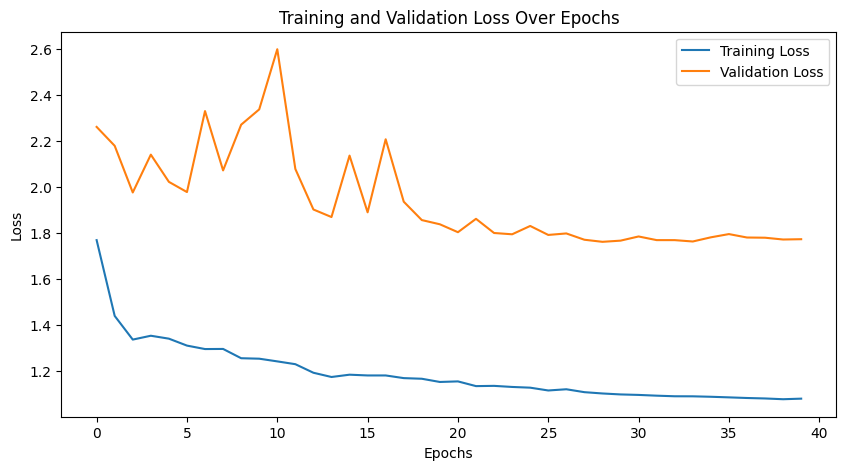

In [16]:
train_losses = [] # For plotting
val_losses = [] # For plotting
for epoch in range(n_epochs):
    # Training step
    learn.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Forward pass
        X_train_input, y_train_input = X_batch.to(device), y_batch.to(device)
        outputs = learn(X_train_input)
        loss = 0
        for i in range(14):
            loss += mae_loss(outputs[:, -i-1, :], y_train_input[:, -i-1, :])
        running_train_loss += loss.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 1cycle
        lr_scheduler.step()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step
    learn.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_input, y_val_input = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = learn(X_val_input)
            val_loss = 0
            for i in range(14):
                val_loss += mae_loss(val_outputs[:, -i-1, :], y_val_input[:, -i-1, :])
            running_val_loss += val_loss.item()
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Save best model (monitor val_loss)
    save_best_model(epoch, avg_val_loss)

    if early_stopping(avg_val_loss):
        print("Early stopping!")
        break
    
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(train_losses)), train_losses, label='Training Loss')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()